In [25]:
!pip install timm


In [26]:
import os, random, math, json, time, itertools
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image

import timm
from torch import nn

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import matplotlib.pyplot as plt



In [3]:
!pip install kaggle


In [6]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)


!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [7]:
!kaggle datasets download alessiocorrado99/animals10


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 89% 520M/586M [00:00<00:00, 1.32GB/s]
100% 586M/586M [00:00<00:00, 1.30GB/s]


In [8]:
!unzip animals10.zip -d animals10_data


Streaming output truncated to the last 5000 lines.
  inflating: animals10_data/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: animals10_data/raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQH

In [9]:
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

In [10]:
DATA_ROOT = Path("/content/animals10_data/raw-img")
assert DATA_ROOT.exists(), f"Data path not found: {DATA_ROOT}"
CLASSES = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Classes:", CLASSES)

Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [11]:
def index_images(root_dir: Path, classes: list[str]) -> pd.DataFrame:
    rows = []
    for ci, cname in enumerate(classes):
        for img_path in (root_dir / cname).glob("*"):
            if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp", ".webp"]:
                continue
            rows.append({"path": str(img_path), "label_name": cname, "label": ci})
    df = pd.DataFrame(rows).sort_values("path").reset_index(drop=True)
    return df

df_all = index_images(DATA_ROOT, CLASSES)
print(df_all.head(), "\n", df_all['label_name'].value_counts())
print("Total images:", len(df_all))


                                                path label_name  label
0  /content/animals10_data/raw-img/cane/OIF-e2bex...       cane      0
1  /content/animals10_data/raw-img/cane/OIP---A27...       cane      0
2  /content/animals10_data/raw-img/cane/OIP---ZId...       cane      0
3  /content/animals10_data/raw-img/cane/OIP---ZRs...       cane      0
4  /content/animals10_data/raw-img/cane/OIP---_cJ...       cane      0 
 label_name
cane          4863
ragno         4821
gallina       3098
cavallo       2623
farfalla      2112
mucca         1866
scoiattolo    1862
pecora        1820
gatto         1668
elefante      1446
Name: count, dtype: int64
Total images: 26179


In [12]:
df_all.head()

,path,label_name,label
0,/content/animals10_data/raw-img/cane/OIF-e2bex...,cane,0
1,/content/animals10_data/raw-img/cane/OIP---A27...,cane,0
2,/content/animals10_data/raw-img/cane/OIP---ZId...,cane,0
3,/content/animals10_data/raw-img/cane/OIP---ZRs...,cane,0
4,/content/animals10_data/raw-img/cane/OIP---_cJ...,cane,0


Corrupt images: 0


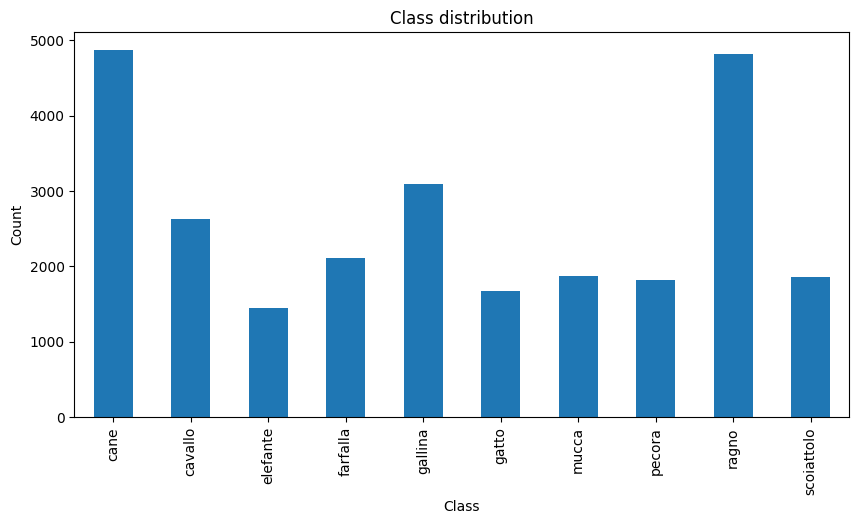

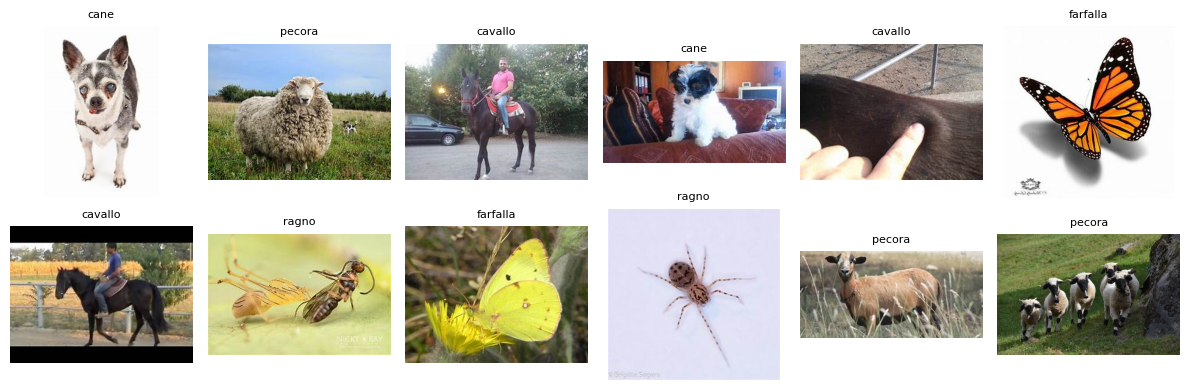

In [13]:
bad = []
for p in df_all['path'].tolist():
    try:
        with Image.open(p) as im:
            im.verify()
    except Exception as e:
        bad.append(p)
print("Corrupt images:", len(bad))
if bad:
    df_all = df_all[~df_all['path'].isin(bad)].reset_index(drop=True)


dist = df_all['label_name'].value_counts().sort_index()
plt.figure(figsize=(10,5))
dist.plot(kind="bar"); plt.title("Class distribution"); plt.xlabel("Class"); plt.ylabel("Count"); plt.show()


def show_grid(df, n=12):
    sample = df.sample(n, random_state=42)
    cols = 6; rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*2, rows*2))
    for i, (_, r) in enumerate(sample.iterrows()):
        plt.subplot(rows, cols, i+1)
        im = Image.open(r['path']).convert("RGB")
        plt.imshow(im); plt.axis("off")
        plt.title(r['label_name'], fontsize=8)
    plt.tight_layout(); plt.show()

show_grid(df_all, n=12)


In [14]:
def stratified_split(df, test_size=0.15, val_size=0.15, seed=42):
    y = df['label'].values
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    idx_trainval, idx_test = next(sss1.split(df, y))
    print('train_idx',idx_trainval,'test_idx',idx_test)

    df_trainval = df.iloc[idx_trainval].reset_index(drop=True)
    df_test     = df.iloc[idx_test].reset_index(drop=True)

    y_tv = df_trainval['label'].values
    val_ratio = val_size / (1 - test_size)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=seed)
    idx_train, idx_val = next(sss2.split(df_trainval, y_tv))
    df_train = df_trainval.iloc[idx_train].reset_index(drop=True)
    df_val   = df_trainval.iloc[idx_val].reset_index(drop=True)
    return df_train, df_val, df_test

df_train, df_val, df_test = stratified_split(df_all, test_size=0.15, val_size=0.15, seed=42)
print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))


print("Train dist:\n", df_train['label_name'].value_counts().sort_index())
print("Val dist:\n",   df_val['label_name'].value_counts().sort_index())
print("Test dist:\n",  df_test['label_name'].value_counts().sort_index())


train_idx [10388  6144  6075 ...  8059   808  2895] test_idx [21678 10292 14039 ...  2690 10556  6436]
Train: 18325 Val: 3927 Test: 3927
Train dist:
 label_name
cane          3404
cavallo       1836
elefante      1012
farfalla      1478
gallina       2168
gatto         1168
mucca         1306
pecora        1274
ragno         3375
scoiattolo    1304
Name: count, dtype: int64
Val dist:
 label_name
cane          729
cavallo       394
elefante      217
farfalla      317
gallina       465
gatto         250
mucca         280
pecora        273
ragno         723
scoiattolo    279
Name: count, dtype: int64
Test dist:
 label_name
cane          730
cavallo       393
elefante      217
farfalla      317
gallina       465
gatto         250
mucca         280
pecora        273
ragno         723
scoiattolo    279
Name: count, dtype: int64


In [15]:
def compute_mean_std(paths, sample_max=2000):
    subset = paths if len(paths) <= sample_max else random.sample(paths, sample_max)
    s = np.zeros(3, dtype=np.float64); sq = np.zeros(3, dtype=np.float64); n_pix = 0
    for p in subset:
        im = Image.open(p).convert("RGB")
        arr = np.asarray(im, dtype=np.float32) / 255.0
        h, w, c = arr.shape
        s  += arr.reshape(-1, 3).sum(axis=0)
        sq += (arr.reshape(-1, 3)**2).sum(axis=0)
        n_pix += h*w
    mean = s / n_pix
    var  = (sq / n_pix) - (mean**2)
    std  = np.sqrt(np.clip(var, 1e-8, None))
    return mean, std

train_paths = df_train['path'].tolist()
MEAN, STD = compute_mean_std(train_paths, sample_max=1500)
print("Estimated mean:", MEAN, "std:", STD)


Estimated mean: [0.46199532 0.4466726  0.37589076] std: [0.29601823 0.28615706 0.28572259]


In [16]:
class SimpleTransforms:
    def __init__(self, size=224, train=True, hflip_p=0.5, mean=(0.5547973  ,0.53158957 ,0.45409678), std=(0.26764544, 0.25904779 ,0.27793258)):
        self.size = size
        self.train = train
        self.hflip_p = hflip_p
        self.mean = np.array(mean, dtype=np.float32)
        self.std  = np.array(std, dtype=np.float32)

    def _resize_shorter_then_center_crop(self, im: Image.Image):
        # keep aspect, resize smaller side to size, then center-crop to square
        w, h = im.size
        if w < h:
            new_w = self.size
            new_h = int(h * self.size / w)
        else:
            new_h = self.size
            new_w = int(w * self.size / h)
        im = im.resize((new_w, new_h), Image.BILINEAR)
        # center crop square
        left = (new_w - self.size)//2
        top  = (new_h - self.size)//2
        im = im.crop((left, top, left+self.size, top+self.size))
        return im

    def __call__(self, im: Image.Image):
        im = im.convert("RGB")
        if self.train and random.random() < self.hflip_p:
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
        im = self._resize_shorter_then_center_crop(im)
        # to tensor [C,H,W], float32 0..1
        arr = np.asarray(im, dtype=np.float32) / 255.0
        arr = (arr - self.mean) / self.std
        arr = np.transpose(arr, (2,0,1))  # HWC -> CHW
        return torch.from_numpy(arr).float()

train_tfms = SimpleTransforms(size=224, train=True,  hflip_p=0.5, mean=MEAN, std=STD)
eval_tfms  = SimpleTransforms(size=224, train=False, hflip_p=0.0, mean=MEAN, std=STD)


In [17]:
class ImageTableDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        path = r['path']; label = int(r['label'])
        im = Image.open(path)  # convert in transform
        if self.transform:
            im = self.transform(im)
        return im, label

train_ds = ImageTableDataset(df_train, transform=train_tfms)
val_ds   = ImageTableDataset(df_val,   transform=eval_tfms)
test_ds  = ImageTableDataset(df_test,  transform=eval_tfms)
len(train_ds), len(val_ds), len(test_ds)


(18325, 3927, 3927)

In [19]:
def make_loader(ds, batch_size=64, shuffle=False, num_workers=2):
    return DataLoader(
        ds, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=True, drop_last=False
    )

BATCH_SIZE = 64
train_loader = make_loader(train_ds, BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = make_loader(val_ds,   BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = make_loader(test_ds,  BATCH_SIZE, shuffle=False, num_workers=2)


xb, yb = next(iter(train_loader))
print("Batch shapes:", xb.shape, yb.shape)


Batch shapes: torch.Size([64, 3, 224, 224]) torch.Size([64])


In [20]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))      # 1x1
        )
        self.classifier = nn.Linear(256, len(CLASSES))

    def forward(self, x):
        x = self.features(x)          # [B, 256, 1, 1]
        x = x.view(x.size(0), -1)     # [B, 256]
        x = self.classifier(x)        # [B, num_classes]
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallCNN(num_classes=len(CLASSES)).to(device)
sum(p.numel() for p in model.parameters())/1e6


0.982538

In [21]:

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0; correct = 0; total = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0; correct = 0; total = 0
    all_preds=[]; all_labels=[]
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_preds.append(preds.cpu().numpy()); all_labels.append(yb.cpu().numpy())
    return (running_loss/total, correct/total,
            np.concatenate(all_preds), np.concatenate(all_labels))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
EPOCHS = 10

best_val_acc = 0.0; best_state = None
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc, va_preds, va_labels = eval_one_epoch(model, val_loader, criterion, device)
    history.append({"epoch": epoch, "train_loss": tr_loss, "train_acc": tr_acc, "val_loss": va_loss, "val_acc": va_acc})
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}


if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "/content/best_smallcnn.pt")

pd.DataFrame(history)


Epoch 01 | train_loss=1.6696 acc=0.4229 | val_loss=1.6749 acc=0.4186
Epoch 02 | train_loss=1.3256 acc=0.5482 | val_loss=1.3599 acc=0.5284
Epoch 03 | train_loss=1.1573 acc=0.6110 | val_loss=1.3298 acc=0.5378
Epoch 04 | train_loss=1.0570 acc=0.6477 | val_loss=1.3098 acc=0.5444
Epoch 05 | train_loss=0.9683 acc=0.6772 | val_loss=1.3096 acc=0.5292
Epoch 06 | train_loss=0.8962 acc=0.7018 | val_loss=1.0453 acc=0.6481
Epoch 07 | train_loss=0.8452 acc=0.7190 | val_loss=1.4120 acc=0.5421
Epoch 08 | train_loss=0.7898 acc=0.7405 | val_loss=1.5121 acc=0.5465
Epoch 09 | train_loss=0.7459 acc=0.7527 | val_loss=0.8968 acc=0.7041
Epoch 10 | train_loss=0.7029 acc=0.7685 | val_loss=1.2359 acc=0.5999


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1.669634,0.422865,1.674881,0.418640
1,2,1.325617,0.548213,1.359884,0.528393
2,3,1.157344,0.610969,1.329767,0.537815
3,4,1.056982,0.647694,1.309759,0.544436
4,5,0.968349,0.677162,1.309575,0.529157
5,6,0.896219,0.701828,1.045298,0.648077
6,7,0.845155,0.719018,1.411999,0.542144
7,8,0.789751,0.740518,1.512089,0.546473
8,9,0.745931,0.752742,0.896771,0.704100
9,10,0.702929,0.768513,1.235899,0.599949


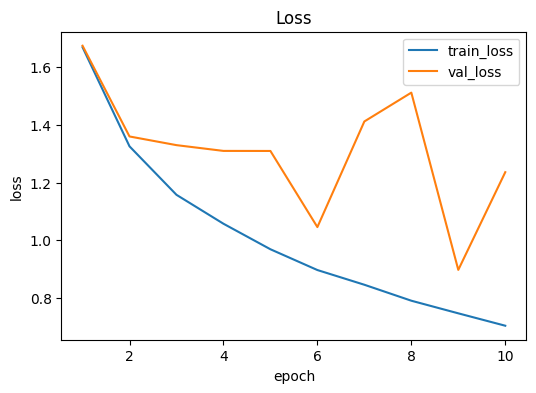

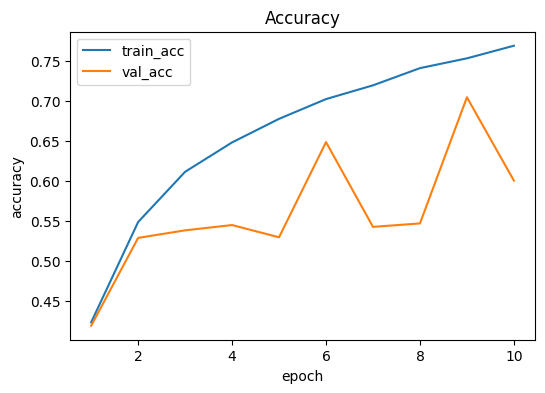

In [22]:

hist_df = pd.DataFrame(history)
plt.figure(figsize=(6,4)); plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train_loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val_loss'); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss"); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist_df['epoch'], hist_df['train_acc'], label='train_acc')
plt.plot(hist_df['epoch'], hist_df['val_acc'], label='val_acc'); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy"); plt.show()


Val accuracy: 0.5999490705373058
              precision    recall  f1-score   support

        cane      0.473     0.853     0.609       729
     cavallo      0.910     0.310     0.462       394
    elefante      0.958     0.424     0.588       217
    farfalla      0.849     0.675     0.752       317
     gallina      0.810     0.723     0.764       465
       gatto      1.000     0.032     0.062       250
       mucca      0.624     0.486     0.546       280
      pecora      1.000     0.264     0.417       273
       ragno      0.517     0.971     0.675       723
  scoiattolo      0.867     0.186     0.307       279

    accuracy                          0.600      3927
   macro avg      0.801     0.492     0.518      3927
weighted avg      0.731     0.600     0.561      3927



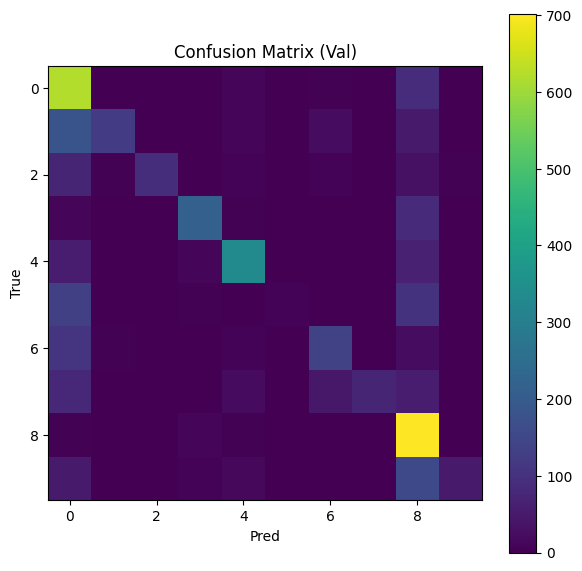

Test accuracy: 0.7035905271199389
              precision    recall  f1-score   support

        cane      0.601     0.789     0.682       730
     cavallo      0.675     0.756     0.713       393
    elefante      0.981     0.488     0.652       217
    farfalla      0.942     0.618     0.747       317
     gallina      0.776     0.798     0.787       465
       gatto      0.985     0.264     0.416       250
       mucca      0.477     0.761     0.586       280
      pecora      0.704     0.487     0.576       273
       ragno      0.846     0.846     0.846       723
  scoiattolo      0.627     0.692     0.658       279

    accuracy                          0.704      3927
   macro avg      0.761     0.650     0.666      3927
weighted avg      0.747     0.704     0.699      3927



In [23]:

cm = confusion_matrix(va_labels, va_preds)
acc = accuracy_score(va_labels, va_preds)
print("Val accuracy:", acc)
print(classification_report(va_labels, va_preds, target_names=CLASSES, digits=3))


plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Val)"); plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


te_loss, te_acc, te_preds, te_labels = eval_one_epoch(model, test_loader, criterion, device)
print("Test accuracy:", te_acc)
print(classification_report(te_labels, te_preds, target_names=CLASSES, digits=3))


Sample: /content/animals10_data/raw-img/cane/OIP-6mSu3p99rTygUcP-WxcvpQHaGE.jpeg
Pred: cane (0.380)


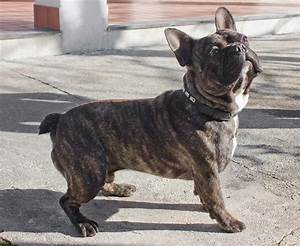

In [24]:

@torch.no_grad()
def predict_one(path, model, tfm, classes):
    im = Image.open(path)
    x = tfm(im).unsqueeze(0).to(device)
    logits = model(x)
    p = torch.softmax(logits, dim=1).cpu().numpy()[0]
    idx = int(np.argmax(p))
    return classes[idx], float(p[idx])

sample_path = df_test.sample(1, random_state=7)['path'].iloc[0]
pred_label, conf = predict_one(sample_path, model, eval_tfms, CLASSES)
print("Sample:", sample_path)
print("Pred:", pred_label, f"({conf:.3f})")
Image.open(sample_path)


## Efficient Net Classifier

In [28]:
class AugTransforms:
    def __init__(self, size=224, train=True, mean=MEAN, std=STD):
        self.size = size
        self.train = train
        self.mean = np.array(mean, dtype=np.float32)
        self.std = np.array(std, dtype=np.float32)

    def __call__(self, im: Image.Image):
        im = im.convert("RGB")
        # Resize + crop
        im = im.resize((self.size, self.size))
        # Augmentations (sadece train)
        if self.train:
            if random.random() < 0.5:
                im = im.transpose(Image.FLIP_LEFT_RIGHT)
            if random.random() < 0.5:
                im = Image.fromarray(
                    np.uint8(np.clip(np.asarray(im)*np.random.uniform(0.8,1.2),0,255))
                )
        arr = np.asarray(im, dtype=np.float32)/255.0
        arr = (arr - self.mean) / self.std
        arr = np.transpose(arr, (2,0,1))
        return torch.from_numpy(arr).float()

train_tfms = AugTransforms(size=224, train=True, mean=MEAN, std=STD)
eval_tfms  = AugTransforms(size=224, train=False, mean=MEAN, std=STD)


In [27]:
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super().__init__()
        # Pretrained EfficientNet
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        in_features = self.backbone.num_features
        # Classifier head with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = EfficientNetClassifier(num_classes=len(CLASSES), dropout=0.4).to(device)

print("Total params (M):", sum(p.numel() for p in model.parameters())/1e6)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Total params (M): 4.020358


In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,        # EfficientNet için küçük lr
    weight_decay=1e-4
)

# LR scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [30]:
EPOCHS = 10
best_val_acc = 0.0
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc, va_preds, va_labels = eval_one_epoch(model, val_loader, criterion, device)

    history.append({
        "epoch": epoch,
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "val_loss": va_loss,
        "val_acc": va_acc
    })

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}

    scheduler.step()

# best modeli yükle
model.load_state_dict(best_state)
torch.save(model.state_dict(), "efficientnet_best.pt")


Epoch 01 | train_loss=0.4693 acc=0.8954 | val_loss=0.0954 acc=0.9740
Epoch 02 | train_loss=0.0820 acc=0.9788 | val_loss=0.0843 acc=0.9761
Epoch 03 | train_loss=0.0411 acc=0.9890 | val_loss=0.0811 acc=0.9758
Epoch 04 | train_loss=0.0264 acc=0.9931 | val_loss=0.0787 acc=0.9791
Epoch 05 | train_loss=0.0161 acc=0.9962 | val_loss=0.0835 acc=0.9784
Epoch 06 | train_loss=0.0117 acc=0.9971 | val_loss=0.0838 acc=0.9789
Epoch 07 | train_loss=0.0087 acc=0.9978 | val_loss=0.0852 acc=0.9784
Epoch 08 | train_loss=0.0062 acc=0.9987 | val_loss=0.0824 acc=0.9791
Epoch 09 | train_loss=0.0058 acc=0.9988 | val_loss=0.0838 acc=0.9786
Epoch 10 | train_loss=0.0049 acc=0.9991 | val_loss=0.0850 acc=0.9791


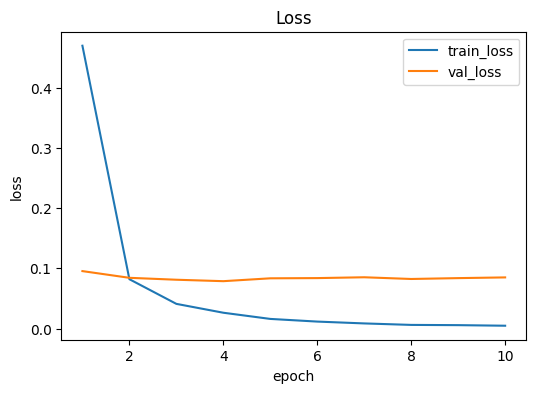

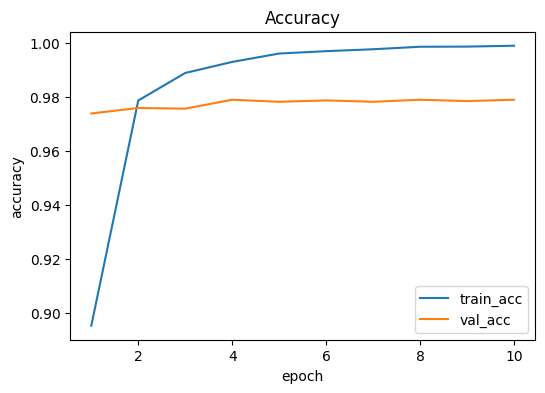

Val accuracy: 0.9791189202953909
              precision    recall  f1-score   support

        cane      0.982     0.984     0.983       729
     cavallo      0.977     0.982     0.980       394
    elefante      0.991     0.963     0.977       217
    farfalla      0.994     0.975     0.984       317
     gallina      0.983     0.989     0.986       465
       gatto      0.980     0.972     0.976       250
       mucca      0.960     0.946     0.953       280
      pecora      0.943     0.971     0.957       273
       ragno      0.988     0.990     0.989       723
  scoiattolo      0.975     0.982     0.979       279

    accuracy                          0.979      3927
   macro avg      0.977     0.975     0.976      3927
weighted avg      0.979     0.979     0.979      3927



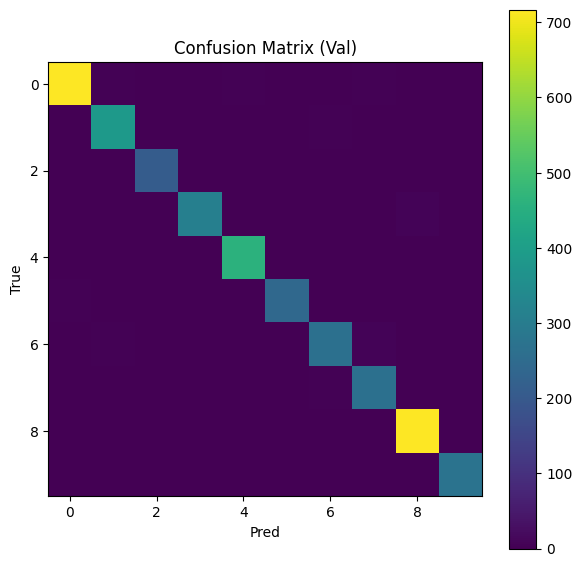

Test accuracy: 0.9768270944741533
              precision    recall  f1-score   support

        cane      0.969     0.984     0.976       730
     cavallo      0.974     0.969     0.972       393
    elefante      0.955     0.977     0.966       217
    farfalla      0.987     0.984     0.986       317
     gallina      0.991     0.987     0.989       465
       gatto      0.988     0.964     0.976       250
       mucca      0.957     0.943     0.950       280
      pecora      0.970     0.941     0.955       273
       ragno      0.990     0.994     0.992       723
  scoiattolo      0.965     0.978     0.972       279

    accuracy                          0.977      3927
   macro avg      0.975     0.972     0.973      3927
weighted avg      0.977     0.977     0.977      3927



In [31]:

hist_df = pd.DataFrame(history)
plt.figure(figsize=(6,4)); plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train_loss')
plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val_loss'); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss"); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist_df['epoch'], hist_df['train_acc'], label='train_acc')
plt.plot(hist_df['epoch'], hist_df['val_acc'], label='val_acc'); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy"); plt.show()

cm = confusion_matrix(va_labels, va_preds)
acc = accuracy_score(va_labels, va_preds)
print("Val accuracy:", acc)
print(classification_report(va_labels, va_preds, target_names=CLASSES, digits=3))


plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Val)"); plt.colorbar(); plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


te_loss, te_acc, te_preds, te_labels = eval_one_epoch(model, test_loader, criterion, device)
print("Test accuracy:", te_acc)
print(classification_report(te_labels, te_preds, target_names=CLASSES, digits=3))


Sample: /content/animals10_data/raw-img/elefante/OIP-o0_pRMvMkSwLnN1pQHN_FwHaF7.jpeg
Pred: elefante (0.999)


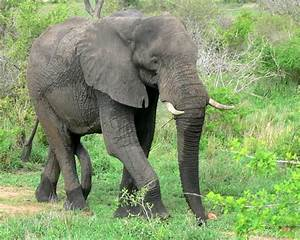

In [37]:

@torch.no_grad()
def predict_one(path, model, tfm, classes):
    im = Image.open(path)
    x = tfm(im).unsqueeze(0).to(device)
    logits = model(x)
    p = torch.softmax(logits, dim=1).cpu().numpy()[0]
    idx = int(np.argmax(p))
    return classes[idx], float(p[idx])

sample_path = df_test.sample(1, random_state=5)['path'].iloc[0]
pred_label, conf = predict_one(sample_path, model, eval_tfms, CLASSES)
print("Sample:", sample_path)
print("Pred:", pred_label, f"({conf:.3f})")
Image.open(sample_path)
